# Model Distillation on CIFAR-10: From ResNet to a Tiny CNN

(I used T4 GPU to run this nb)

# Setup and imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True  # slower, but reproducible
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Load and Preprocess CIFAR-10 Dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

classes = train_dataset.classes

# Define Teacher Model (ResNet18)

In [4]:
# weights=None -> we train from scratch
teacher_model = models.resnet18(weights=None, num_classes=10)
teacher_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Define Student Model (Small CNN)

In [5]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # [B, 16, 32, 32]
        x = F.max_pool2d(x, 2)      # [B, 16, 16, 16]
        x = F.relu(self.conv2(x))   # [B, 32, 16, 16]
        x = F.max_pool2d(x, 2)      # [B, 32, 8, 8]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

student_model = SmallCNN().to(device)

# Distillation Loss Function

In [6]:
def distillation_loss(student_logits, teacher_logits, labels, T=2.0, alpha=0.7):
    soft_loss = F.kl_div(
        F.log_softmax(student_logits / T, dim=1),
        F.softmax(teacher_logits / T, dim=1),
        reduction='batchmean'
    ) * (T * T)
    hard_loss = F.cross_entropy(student_logits, labels)
    return alpha * soft_loss + (1 - alpha) * hard_loss

# Train Teacher (or Load Pretrained)

In [7]:
def train(model, optimizer, criterion, dataloader, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.2f}")

In [8]:
teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)
train(teacher_model, teacher_optimizer, nn.CrossEntropyLoss(), train_loader, epochs=15)

Epoch 1/15, Loss: 528.95
Epoch 2/15, Loss: 374.70
Epoch 3/15, Loss: 306.98
Epoch 4/15, Loss: 259.94
Epoch 5/15, Loss: 220.16
Epoch 6/15, Loss: 181.52
Epoch 7/15, Loss: 149.70
Epoch 8/15, Loss: 120.95
Epoch 9/15, Loss: 98.87
Epoch 10/15, Loss: 80.34
Epoch 11/15, Loss: 65.77
Epoch 12/15, Loss: 55.11
Epoch 13/15, Loss: 50.27
Epoch 14/15, Loss: 40.73
Epoch 15/15, Loss: 38.46


# Evaluate Accuracy

In [9]:
def test(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    print(f"Accuracy: {100 * correct / total:.2f}%")

In [10]:
print("Teacher:")
test(teacher_model, test_loader)

Teacher:
Accuracy: 75.54%


# Distill Knowledge to Student

In [11]:
def train_student(student_model, teacher_model, train_loader, T=2.0, alpha=0.7, epochs=5):
    teacher_model.eval()
    student_model.train()
    optimizer = optim.Adam(student_model.parameters(), lr=0.001)
    for epoch in range(epochs):
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                teacher_logits = teacher_model(x)
            student_logits = student_model(x)
            loss = distillation_loss(student_logits, teacher_logits, y, T, alpha)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Distill Loss: {total_loss:.2f}")

Before we train student - we can check the accuracy for a randomly initialised weights. The expectation is that that should be a random guess which should result in 10% +- some random variation (we have 10 classes).

In [12]:
print("Student:")
test(student_model, test_loader)

Student:
Accuracy: 9.89%


In [13]:
train_student(
    student_model=student_model,
    teacher_model=teacher_model,
    train_loader=train_loader,
    T=2.0,
    alpha=0.7,
    epochs=5
)

Epoch 1/5, Distill Loss: 1595.12
Epoch 2/5, Distill Loss: 1224.41
Epoch 3/5, Distill Loss: 1075.55
Epoch 4/5, Distill Loss: 966.43
Epoch 5/5, Distill Loss: 886.69


# Evaluate Accuracy of Original and Distilled models

In [14]:
print("Teacher:")
test(teacher_model, test_loader)
print("Student:")
test(student_model, test_loader)

Teacher:
Accuracy: 75.54%
Student:
Accuracy: 65.65%


# Grid of predictions

In [15]:
import matplotlib.pyplot as plt
import torchvision
import random

def show_random_predictions(model, dataloader, class_names, n_images=16):
    model.eval()
    inputs_all, labels_all = next(iter(dataloader))  # Get one batch
    indices = random.sample(range(len(inputs_all)), n_images)

    inputs = inputs_all[indices].to(device)
    labels = labels_all[indices].to(device)

    with torch.no_grad():
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

    fig = plt.figure(figsize=(12, 8))
    for i in range(n_images):
        ax = plt.subplot(int(n_images**0.5), int(n_images**0.5), i + 1)
        img = inputs[i].cpu() * 0.5 + 0.5  # Unnormalize
        img = torchvision.transforms.ToPILImage()(img)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"P: {class_names[preds[i]]}\nT: {class_names[labels[i]]}")
    plt.tight_layout()
    plt.show()

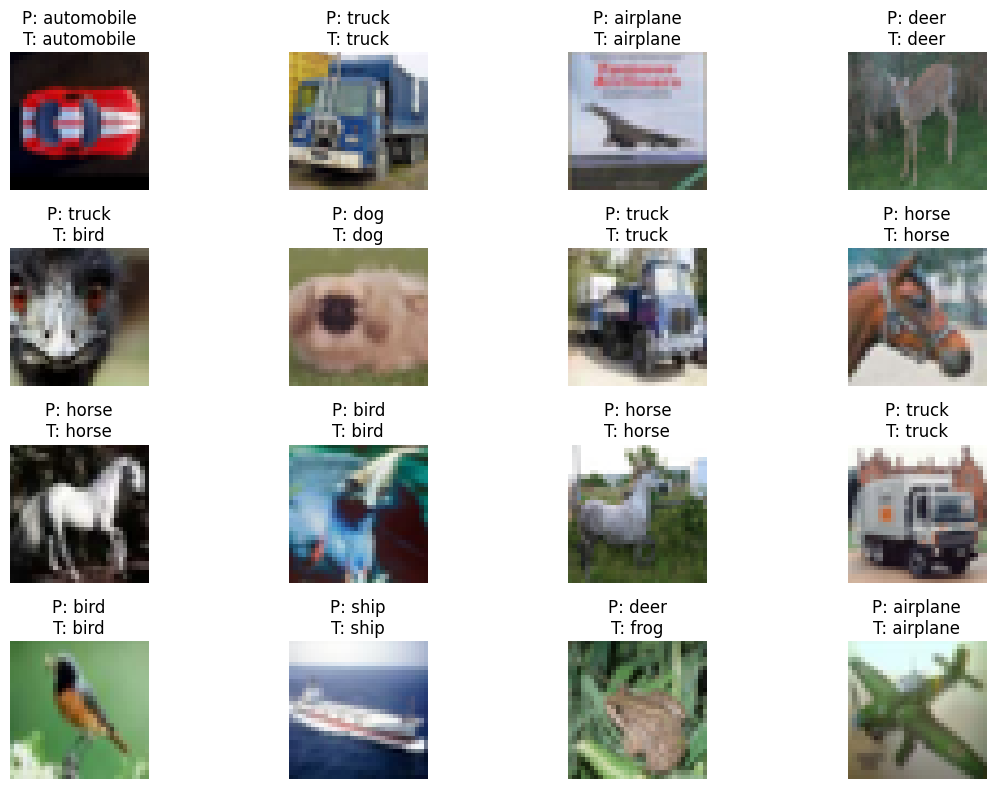

In [16]:
# Show sample predictions from teacher model
show_random_predictions(teacher_model, test_loader, classes, n_images=16)

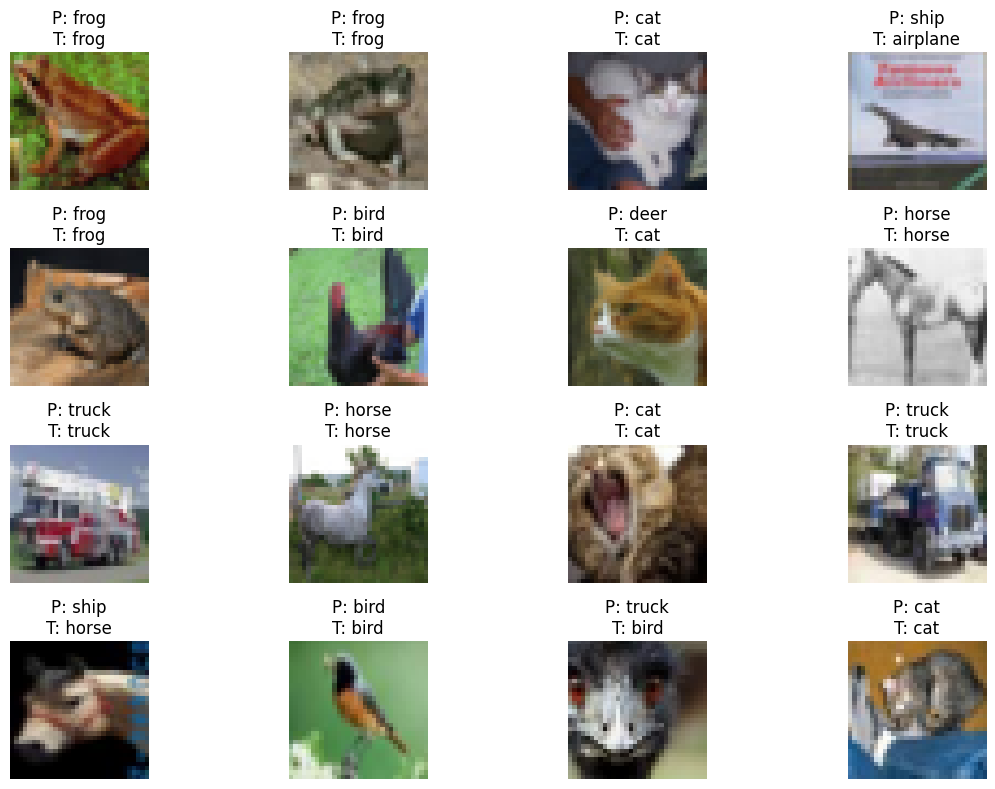

In [17]:
# Show sample predictions from student model
show_random_predictions(student_model, test_loader, classes, n_images=16)

# Capacity and Size of both models

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Teacher model params: {count_parameters(teacher_model):,}")
print(f"Student model params: {count_parameters(student_model):,}")

Teacher model params: 11,181,642
Student model params: 210,998


In [19]:
# Save both models temporarily
torch.save(teacher_model.state_dict(), "teacher.pth")
torch.save(student_model.state_dict(), "student.pth")

In [20]:
# Now check the physical space on disk required for each
import os

teacher_size = os.path.getsize("teacher.pth") / 1024**2  # MB
student_size = os.path.getsize("student.pth") / 1024**2  # MB

print(f"Teacher model file size: {teacher_size:.2f} MB")
print(f"Student model file size: {student_size:.2f} MB")

Teacher model file size: 42.73 MB
Student model file size: 0.81 MB


# Final Comparison: Teacher vs Student

| Metric                | Teacher (ResNet18) | Student (SmallCNN) | Reduction |
|-----------------------|--------------------|---------------------|-----------|
| Accuracy              | 75.54%             | 65.65%              | ~87% retained |
| Params                | 11.2M              | 211K                | ~98% fewer |
| Model size on disk    | 42.7 MB            | 0.81 MB             | ~98% smaller |

> A compact student model that’s 98% smaller yet retains most of the performance — that’s model distillation at work.

Want more? Try deeper students, data augmentation, or pretrained teachers.
